In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lombscargle

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def distance(data):
    distances = pd.DataFrame()    
    # calculate distance in km between points
    data['dx'] = np.insert(sw.distance(data['Lon'].values, data['Lat'].values, 0),0,0)/1000
    data['x'] = np.cumsum(data['dx'])

    return data  

def bin(pgram, periods, bins, bin_mid):
    
    y = periods
    
    binned = pd.DataFrame()
    bin_count = np.zeros(len(bins)-1)
    binned['k_mid'] = bin_mid
          
    z = pgram # bead attribute

    digitized = np.digitize(y, bins)
    bin_count = [np.shape(z[digitized == i])[0] for i in range(1, len(bins))]

    bin_means = [np.nanmean(z[digitized == i]) for i in range(1, len(bins))]
    bin_std = [np.nanstd(z[digitized == i]) for i in range(1, len(bins))]
        
    binned['var'] = bin_means
    binned['std'] = bin_std

    return binned


In [3]:
# import data

maxlat = 35

KM = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/KM1314_vSept16.csv', sep = ',')
KM['density'] = sw.rho(KM['S'].values,KM['T'].values,0)
KM = distance(KM)
KM = KM[KM['Lat']<maxlat].dropna()

ST = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/STUD08_vSept16.csv', sep = ',')
ST['density'] = sw.rho(ST['S'].values,ST['T'].values,0)
ST = distance(ST)
ST = ST[ST['Lat']<maxlat].dropna()

print ST.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo (calibrated)',
       u'TrueO2Ar', u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn',
       u'Air-sea flux', u'density', u'dx', u'x'],
      dtype='object')


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


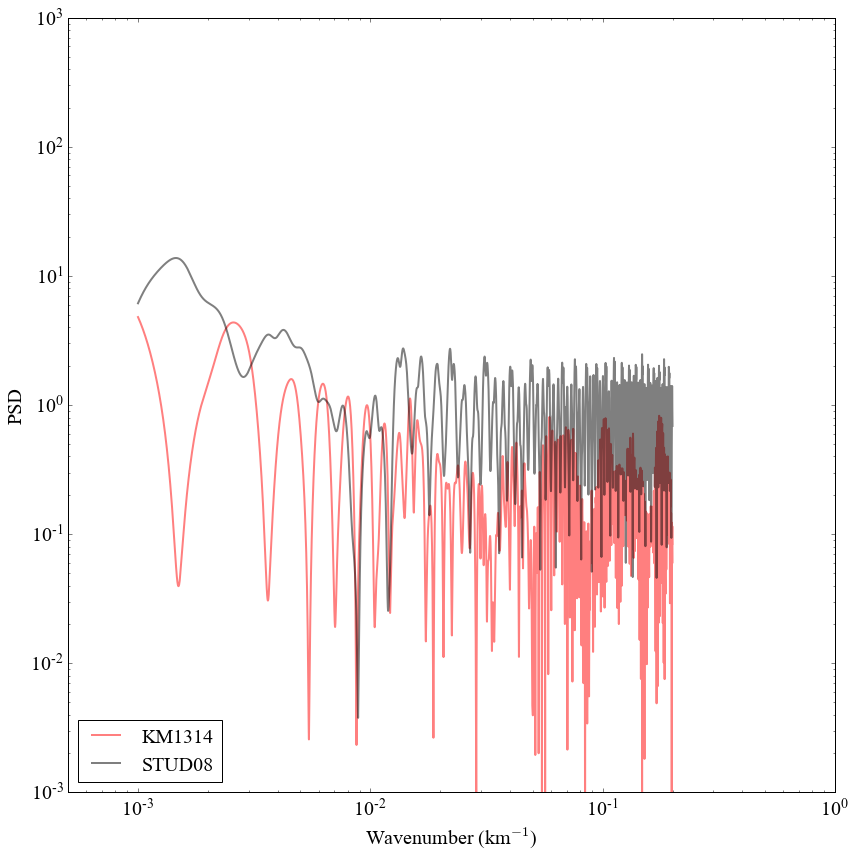

In [4]:
# Lomb-Scargle periodogram

nout = 100000 # number of frequency-space points at which to calculate the signal strength (output)
periods = np.linspace(5, 1000, nout)
freqs = 1.0 / periods
angular_freqs = 2 * np.pi * freqs

pgram = lombscargle(KM['x'].values, KM['Air-sea flux'].values-KM['Air-sea flux'].mean(), angular_freqs)
normalized_pgramKM = np.sqrt(4 * (pgram / len(KM['Air-sea flux'].values)))

pgram = lombscargle(KM['x'].values, KM['T'].values- KM['T'].mean(), angular_freqs)
normalized_pgramKMT = np.sqrt(4 * (pgram / len(KM['T'].values)))

pgram = lombscargle(ST['x'].values, ST['Air-sea flux'].values- ST['Air-sea flux'].mean(), angular_freqs)
normalized_pgramST = np.sqrt(4 * (pgram / len(ST['Air-sea flux'].values)))

pgram = lombscargle(ST['x'].values, ST['T'].values- ST['T'].mean(), angular_freqs)
normalized_pgramSTT = np.sqrt(4 * (pgram / len(ST['T'].values)))


fig1 = plt.figure(3, figsize=(12,12), dpi = 600)
plt.loglog(1/periods, normalized_pgramKM**2, 'r', label = 'KM1314', lw = 2, alpha = 0.5)
#plt.loglog(1/periods, normalized_pgramTok1T**2, 'k', label = 'T - May 2011', lw = 2)

plt.loglog(1/periods, normalized_pgramST**2, 'k', label = 'STUD08', lw = 2, alpha = 0.5)
#plt.loglog(1/periods, normalized_pgramTok3T**2, 'grey', label = 'T - Sept 2011', lw = 2)


plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavenumber (km$^{-1}$)', fontsize = 20)

plt.axis([0.0005, 1, 0.001, 1000])

plt.show()

In [12]:
bins = 10**(np.arange(0,3,0.05))
bin_mid = bins[:(len(bins)-1)] + np.diff(bins)/2

binnedKM = bin(normalized_pgramKM, periods, bins, bin_mid)
binnedST = bin(normalized_pgramST, periods, bins, bin_mid)

binnedKMT = bin(normalized_pgramKMT, periods, bins, bin_mid)
binnedSTT = bin(normalized_pgramSTT, periods, bins, bin_mid)


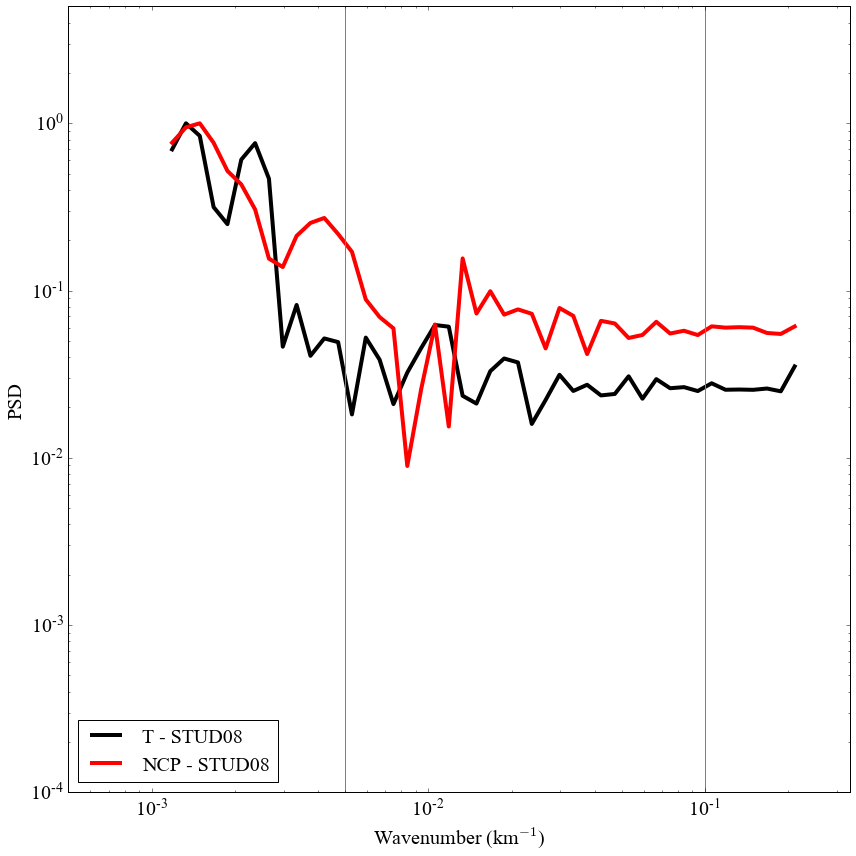

In [13]:
fig1 = plt.figure(3, figsize=(12,12), dpi = 600)
plt.loglog(1./(binnedSTT['k_mid'].values), (binnedSTT['var'].values/binnedSTT['var'].max())**2, 'k', label = 'T - STUD08', lw = 4)
plt.loglog(1./(binnedST['k_mid'].values), (binnedST['var'].values/binnedST['var'].max())**2, 'r', label = 'NCP - STUD08', lw = 4)


plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavenumber (km$^{-1}$)', fontsize = 20)

plt.axvline(1./200, color = 'grey')
plt.axvline(1./10, color = 'grey')

plt.axis([0.0005, 1./3, 0.0001, 5])

plt.show()

#fig1.savefig('../figures/T_NCP_spectra_May11.png', bbox_inches='tight', dpi=600)

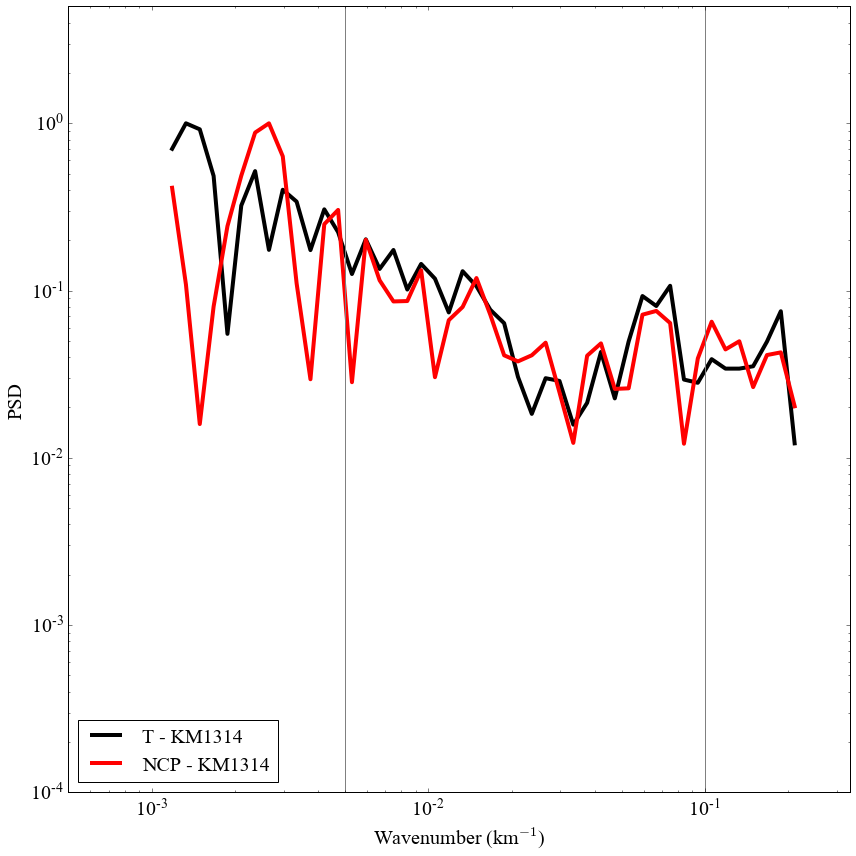

In [14]:
fig1 = plt.figure(3, figsize=(12,12), dpi = 600)
#plt.loglog(1/periods, normalized_pgramTok1T**2, 'r', lw = 2, alpha = 0.25)
#plt.loglog(1./(binnedT1T['k_mid'].values), binnedT1T['var'].values**2, 'grey', label = 'T - May 2011', lw = 4)

plt.loglog(1./(binnedKMT['k_mid'].values), (binnedKMT['var'].values/binnedKMT['var'].max())**2, 'k', label = 'T - KM1314', lw = 4)
plt.loglog(1./(binnedKM['k_mid'].values), (binnedKM['var'].values/binnedKM['var'].max())**2, 'r', label = 'NCP - KM1314', lw = 4)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavenumber (km$^{-1}$)', fontsize = 20)

plt.axvline(1./200, color = 'grey')
plt.axvline(1./10, color = 'grey')

plt.axis([0.0005, 1./3, 0.0001, 5])

plt.show()

#fig1.savefig('../figures/T_NCP_spectra_September11.png', bbox_inches='tight', dpi=600)

In [15]:
print KM['dx'].mean()

0.791607356729
